Обучить сиамскую сеть для верификации лиц на датасете LFW

### Библиотеки


In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds

import os
import random

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

### Набор данных LFW

LFW-deepfunneled содержит 13'233 цветных изображений лиц 5'749 персон; размер каждого изображения – 250*250 пикселей.

In [ ]:
tfds.disable_progress_bar()
train_ds, ds_info = tfds.load(
    'lfw',
    as_supervised=True,
    with_info=True,
    split='train[:1000]',
)

### Визуализация датасета

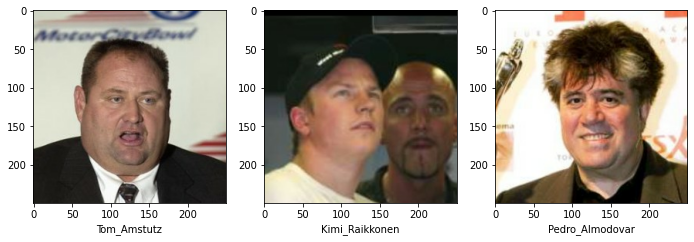

In [ ]:
fig = plt.figure(figsize=(20, 30))
for i, example in enumerate(train_ds.take(3)):
    image, label = example[1], example[0]
    plt.subplot(1, 5, i+1)
    plt.imshow(image.numpy().astype(np.float32)/255)
    plt.xlabel(label.numpy().decode())

### Функции

In [ ]:
MARGIN = 5.0

def contrastive_loss(embs, labels):
    bs = embs.shape[0]
    embs1 = embs[:bs//2, :]
    embs2 = embs[bs//2:, :]
    labels1 = labels[:bs//2]
    labels2 = labels[bs//2:]

    d2 = tf.reduce_sum(tf.square(embs1 - embs2), axis=1)
    d =  tf.sqrt(d2)
    z = tf.cast(labels1 == labels2, tf.float32)
    
    return tf.reduce_mean(z * d2 + (1-z) * tf.maximum(0, MARGIN - d)**2)

### Создание модели CNN

In [ ]:
EMB_SIZE = 64

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Conv2D(32, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(EMB_SIZE, activation=None),
])

## Подготовка пайплайна данных

In [ ]:
def normalize_example(label, image):
    return label, tf.cast(image, tf.float32) / 255.

In [ ]:
BATCH_SIZE = 128
NUM_EPOCHS = 1

train_ds = train_ds.map(normalize_example)
train_ds = train_ds.shuffle(buffer_size=1000)
train_ds = train_ds.repeat(NUM_EPOCHS)
train_ds = train_ds.batch(BATCH_SIZE)

In [ ]:
train_ds

<BatchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 250, 250, 3), dtype=tf.float32, name=None))>

## Подготовка к обучению

In [ ]:
LEARNING_RATE = 0.001
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)

## Обучение модели

In [ ]:
%%time

for iteration, (labels, images) in enumerate(train_ds):
    
    # Forward
    with tf.GradientTape() as tape:
        embs = model(images)
        loss_value = contrastive_loss(embs, labels)
        
    # Backward
    grads = tape.gradient(loss_value, model.variables)
    optimizer.apply_gradients(zip(grads, model.variables))

    if iteration % 200 == 0:
        print('[{}] Loss: {}'.format(iteration, loss_value.numpy()))

[0] Loss: 18.852231979370117
CPU times: user 4min 40s, sys: 8.37 s, total: 4min 48s
Wall time: 3min 38s


## Тестирование на новых данных

In [ ]:
def load_and_prepare_image(fpath):
    import imageio
    from skimage.transform import resize
    img = imageio.imread(fpath, pilmode="RGB")
    img = img.astype(np.float32)/255
    img = resize(img, (250, 250, 3), mode='reflect', anti_aliasing=True)
    img = np.reshape(img, (250, 250, 3))
    return img

In [ ]:
img_1 = load_and_prepare_image('/content/onidzuka1.jpg')
img_2 = load_and_prepare_image('/content/onidzuka2.jpg')
img_3 = load_and_prepare_image('/content/vash.jpg')

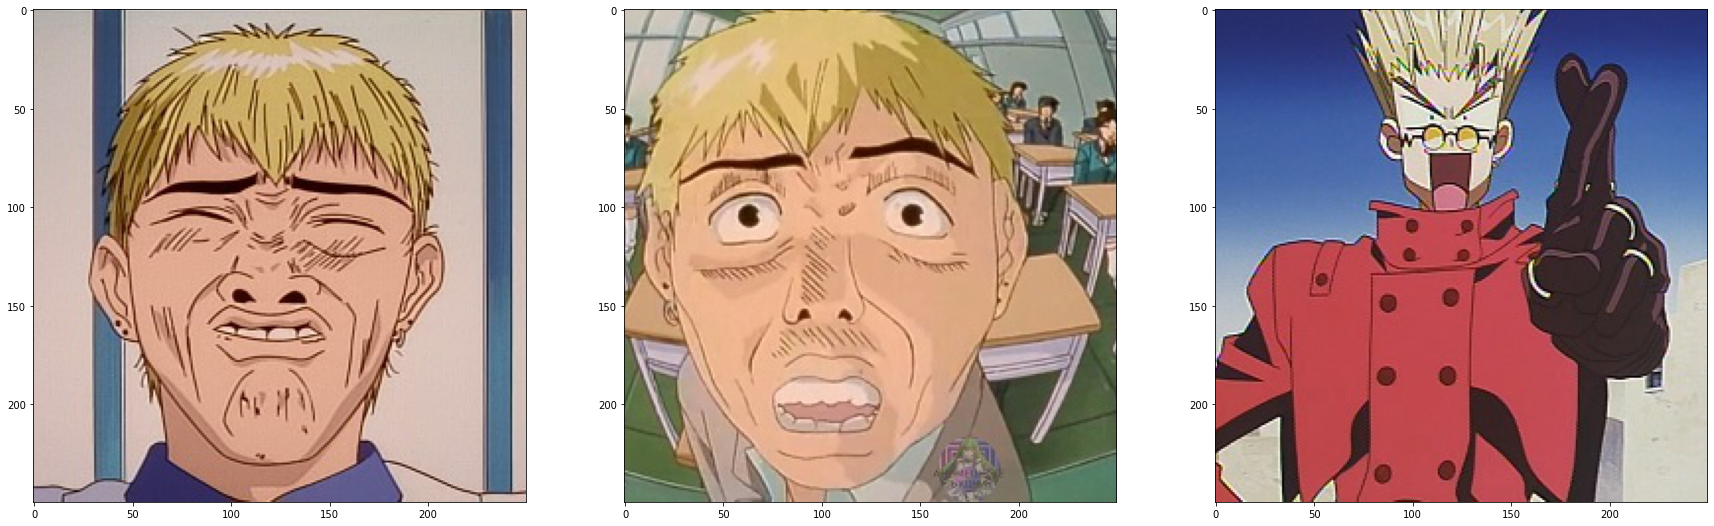

In [ ]:
fig = plt.figure(figsize=(30,10))
ax = fig.add_subplot(1, 3, 1)
ax.imshow(img_1)
ax = fig.add_subplot(1, 3, 2)
ax.imshow(img_2)
ax = fig.add_subplot(1, 3, 3)
ax.imshow(img_3)

plt.show()

In [ ]:
test_x = np.stack((img_1, img_2, img_3), axis=0)
test_embs = model(test_x)

In [ ]:
train_embs = model(images)
emb_tr2 = train_embs[0,:] #onidzuka1
emb_tr1 = train_embs[1,:] #onidzuka2
emb_tr1 = train_embs[1,:] #vash

In [ ]:
emb1 = test_embs[0,:] #onidzuka1
emb2 = test_embs[1,:] #onidzuka2
emb3 = test_embs[2,:] #vash

In [ ]:
def diff(e1, e2):
    return np.sum((e1 - e2)**2) ** 0.5

In [ ]:
print('Onidzuka1 vs Onidzuka2: ', diff(emb2, emb_tr2))
print('Onidzuka1 vs Vash: ', diff(emb1, emb_tr1))

Onidzuka1 vs Onidzuka2:  184.36201225442295
Onidzuka1 vs Vash:  249.65728071197924
